In [1]:
import jax
import jax.numpy as jnp
import optax

# Force CPU (optional)
jax.config.update("jax_platform_name", "cpu")

In [2]:
from dataclasses import dataclass
from flax import linen as nn

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
@dataclass
class LSTMTabModelConfig:
    """Configuration for LSTM-based tabular model."""
    embedding_dim: int = 16
    hidden_dim: int = 32
    num_layers: int = 2
    context_length: int = 32
    output_dim: int = 1
    dropout: float = 0.2


class LSTMTabModel(nn.Module):
    """LSTM-based model for tabular/time-series data."""
    config: LSTMTabModelConfig

    @nn.compact
    def __call__(self, x: jax.Array, train: bool = False) -> jax.Array:
        # Input embedding
        x = nn.Dense(
            features=self.config.embedding_dim,
            name="token_embedding",
        )(x)
        
        # Positional embedding
        pos_emb = self.param(
            "pos_embedding",
            nn.initializers.normal(stddev=0.02),
            (self.config.context_length, self.config.embedding_dim),
        )
        x = x + pos_emb[:x.shape[1]]
        
        # Dropout after embedding
        x = nn.Dropout(rate=self.config.dropout)(x, deterministic=not train)
        
        # Stack of LSTM layers
        for i in range(self.config.num_layers):
            lstm = nn.RNN(
                nn.LSTMCell(features=self.config.hidden_dim),
                name=f"lstm_layer_{i}"
            )
            x = lstm(x)
            x = nn.Dropout(rate=self.config.dropout)(x, deterministic=not train)
        
        # Layer norm before output
        x = nn.LayerNorm(name="output_norm")(x)
        
        # Output projection
        logits = nn.Dense(
            features=self.config.output_dim,
            use_bias=False,
            dtype=jnp.float32,
            name="pred_head",
        )(x)
        return logits

In [43]:
@dataclass
class ModelConfig:
    batch_size: int = 1
    embedding_dim: int = 16
    hidden_dim: int = 32
    num_layers: int = 2
    context_length: int = 32

cfg = ModelConfig(
    batch_size=16,
)

S = cfg.context_length  # context length

lstm_config = LSTMTabModelConfig(
    embedding_dim=cfg.embedding_dim,
    hidden_dim=cfg.hidden_dim,
    num_layers=cfg.num_layers,
    context_length=cfg.context_length,
    dropout=0.2,
)

In [44]:
# Simple AR(1) deterministic process: x_t = phi * x_{t-1}
# This is a sanity check - the model should learn phi perfectly
def make_ar1_generator(phi, x0_scale, rng):
    """Generate deterministic AR(1) sequences.
    
    AR(1) process (deterministic, no noise):
        x_t = phi * x_{t-1}
    
    With |phi| < 1, sequences decay/oscillate toward 0.
    With phi > 0, monotonic decay.
    With phi < 0, oscillating decay.
    
    Args:
        phi: AR(1) coefficient, |phi| < 1 for stationarity
        x0_scale: Scale for random initial values
        rng: numpy random generator
    
    Returns:
        Generator function that produces sequences
    """
    def gen(n_samples, horizon):
        # seqs shape: (n_samples, horizon+1, 2) where last dim is [value, mask]
        seqs = np.zeros((n_samples, horizon + 1, 2))
        ts = np.full(n_samples, horizon + 1, dtype=int)  # all sequences are full length
        cs = np.ones(n_samples, dtype=bool)  # all "censored" (no early termination)
        
        for i in range(n_samples):
            # Random initial value
            x0 = x0_scale * rng.normal()
            seqs[i, 0, 0] = x0
            seqs[i, 0, 1] = 1  # mask = 1 (valid)
            
            # Deterministic AR(1) evolution
            for j in range(1, horizon + 1):
                seqs[i, j, 0] = phi * seqs[i, j-1, 0]
                seqs[i, j, 1] = 1  # mask = 1 (valid)
        
        return seqs.astype(np.float32), ts, cs
    return gen

In [45]:
rng = np.random.default_rng(seed=0)

# AR(1) parameters
phi = 0.9      # AR coefficient, |phi| < 1 for stationarity
x0_scale = 2.0  # Scale of initial values
horizon = 99

# Create generator
gen = make_ar1_generator(phi, x0_scale, rng)
seqs, ts, cs = gen(n_samples=1000, horizon=horizon)

print(f"AR(1) process: x_t = {phi} * x_{{t-1}}")
print(f"The model should learn to predict: x_{{t+1}} = {phi} * x_t")

AR(1) process: x_t = 0.9 * x_{t-1}
The model should learn to predict: x_{t+1} = 0.9 * x_t


In [46]:
seqs.shape

(1000, 100, 2)

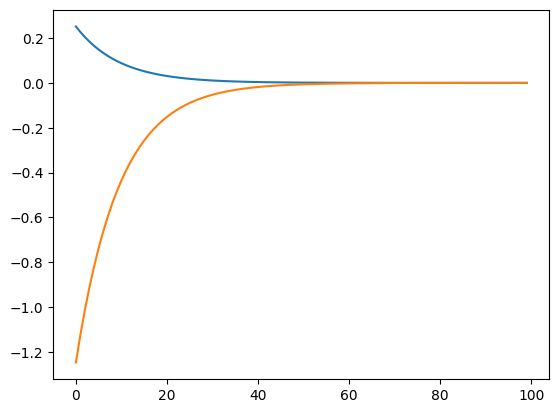

In [47]:
plt.plot(seqs[0][:,0])
plt.plot(seqs[10][:,0])

In [48]:
# All sequences are full-length (no early termination in AR(1))
print(f"Full-length sequences: {cs.sum()}/{len(cs)} = {cs.sum()/len(cs):.1%}")

Full-length sequences: 1000/1000 = 100.0%


In [49]:
# Training setup

# Dataset: generate long sequences and chunk them with sliding window
class ChunkedDataset:
    """Generate long sequences and yield chunks via sliding window."""
    
    def __init__(self, gen_fn, n_seqs=100, horizon=200, chunk_size=32, stride=1):
        self.gen_fn = gen_fn
        self.chunk_size = chunk_size
        self.stride = stride
        self.refresh(n_seqs, horizon)
    
    def refresh(self, n_seqs=100, horizon=200):
        """Generate new sequences and extract chunks."""
        seqs, _, _ = self.gen_fn(n_samples=n_seqs, horizon=horizon)
        self.all_chunks_x = []
        self.all_chunks_mask = []
        
        for i in range(len(seqs)):
            seq_x = seqs[i, :, :1]      # (L, 1) - values
            seq_mask = seqs[i, :, -1]   # (L,) - validity mask
            valid_len = int(seq_mask.sum())
            
            # Extract chunks using sliding window (only from valid region)
            for start in range(0, max(1, valid_len - self.chunk_size + 1), self.stride):
                end = start + self.chunk_size
                if end <= valid_len:
                    self.all_chunks_x.append(seq_x[start:end])
                    self.all_chunks_mask.append(seq_mask[start:end])
        
        self.all_chunks_x = np.array(self.all_chunks_x)      # (N_chunks, chunk_size, 1)
        self.all_chunks_mask = np.array(self.all_chunks_mask) # (N_chunks, chunk_size)
        print(f"Created {len(self.all_chunks_x)} chunks from {n_seqs} sequences")
    
    def sample_batch(self, batch_size, rng_key=None):
        """Sample a random batch of chunks."""
        if rng_key is None:
            idx = np.random.choice(len(self.all_chunks_x), size=batch_size, replace=True)
        else:
            idx = jax.random.choice(rng_key, len(self.all_chunks_x), shape=(batch_size,), replace=True)
        return self.all_chunks_x[idx], self.all_chunks_mask[idx]

# Create dataset
dataset = ChunkedDataset(gen, n_seqs=1000, horizon=100, chunk_size=S+1, stride=1)

# Initialize model
lstm = LSTMTabModel(config=lstm_config)
rng = jax.random.PRNGKey(42)
param_rng, dropout_rng = jax.random.split(rng)
params = lstm.init({"params": param_rng, "dropout": dropout_rng}, jnp.ones((1, S, 1)))

Created 69000 chunks from 1000 sequences


In [50]:
# Loss: MSE for next-token prediction with padding mask
def loss_fn(params, x, mask, rng):
    preds = lstm.apply(params, x[:, :-1], train=True, rngs={"dropout": rng})  # (B, S, 1)
    target = x[:, 1:]
    
    # Masks for valid positions
    input_mask = mask[:, :-1]   # (B, S-1) - is input at position t valid?
    target_mask = mask[:, 1:]   # (B, S-1) - is target at position t+1 valid?
    combined_mask = input_mask * target_mask  # both must be valid
    
    squared_errors = (preds - target) ** 2  # (B, S-1)
    masked_errors = squared_errors * combined_mask
    
    # Mean over valid positions only
    return jnp.sum(masked_errors) / (jnp.sum(combined_mask) + 1e-8)

# Training step
@jax.jit
def train_step(params, opt_state, x, mask, rng):
    loss, grads = jax.value_and_grad(loss_fn)(params, x, mask, rng)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Optimizer
optimizer = optax.adam(1e-4)
opt_state = optimizer.init(params)

In [56]:
# Simple training loop (no random left-padding)
n_steps = 500
batch_size = 32
rng = jax.random.PRNGKey(0)

for step in range(n_steps):
    # Sample batch of full chunks from dataset
    x_batch, mask_batch = dataset.sample_batch(batch_size)
    x_batch = jnp.array(x_batch)
    mask_batch = jnp.array(mask_batch)
    
    rng, step_rng = jax.random.split(rng)
    params, opt_state, loss = train_step(params, opt_state, x_batch, mask_batch, step_rng)
    
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.6f}")

Step 0, Loss: 2.147344
Step 100, Loss: 1.113370
Step 200, Loss: 0.800593
Step 300, Loss: 0.559970
Step 400, Loss: 0.600561


In [57]:
# Causality test: verify no future leakage
# If we change future values, predictions at earlier timesteps should NOT change

def test_no_future_leakage():
    """
    Test that predictions at time t don't depend on inputs at time > t.
    This verifies the model is truly causal (no information leakage from the future).
    """
    seqs_test, _, _ = gen(n_samples=1, horizon=S)
    x_orig = jnp.array(seqs_test[:, :S, :1])  # (1, S, 1) - exactly context_length
    
    # Get predictions with original input
    preds_orig = lstm.apply(params, x_orig, train=False)
    
    # Modify future values (last 10 timesteps) with a large perturbation
    x_modified = x_orig.at[:, -10:, :].set(x_orig[:, -10:, :] + 100.0)
    preds_modified = lstm.apply(params, x_modified, train=False)
    
    # Predictions for early timesteps (before modification) should be IDENTICAL
    # because causal models can only see past, not future
    early_diff = jnp.abs(preds_orig[:, :-10, :] - preds_modified[:, :-10, :]).max()
    
    if early_diff < 1e-5:
        print(f"✓ Causality test PASSED: No future leakage detected")
        print(f"  Max diff in early predictions: {early_diff:.2e}")
    else:
        print(f"✗ Causality test FAILED: Future information leaked!")
        print(f"  Max diff in early predictions: {early_diff:.2e}")
    
    return early_diff < 1e-5

test_no_future_leakage()

✓ Causality test PASSED: No future leakage detected
  Max diff in early predictions: 0.00e+00


Array(True, dtype=bool)

In [58]:
# Evaluation on test set (fresh sequences, not seen during training)
def evaluate(params, gen_fn, n_seqs=50, horizon=150, chunk_size=S):
    """Evaluate model on fresh test sequences."""
    # Generate new test sequences
    test_dataset = ChunkedDataset(gen_fn, n_seqs=n_seqs, horizon=horizon, 
                                   chunk_size=chunk_size, stride=chunk_size)
    
    x_test = jnp.array(test_dataset.all_chunks_x)
    mask_test = jnp.array(test_dataset.all_chunks_mask)
    
    preds = lstm.apply(params, x_test, train=False)
    
    # Compute MSE only on valid positions
    input_mask = mask_test[:, :-1]
    target_mask = mask_test[:, 1:]
    combined_mask = input_mask * target_mask
    
    squared_errors = (preds[:, :-1, 0] - x_test[:, 1:, 0]) ** 2
    masked_errors = squared_errors * combined_mask
    mse = jnp.sum(masked_errors) / (jnp.sum(combined_mask) + 1e-8)
    
    print(f"Test MSE: {mse:.6f}")
    return x_test, preds, mse

x_test, preds_test, test_mse = evaluate(params, gen)

Created 200 chunks from 50 sequences
Test MSE: 0.011598


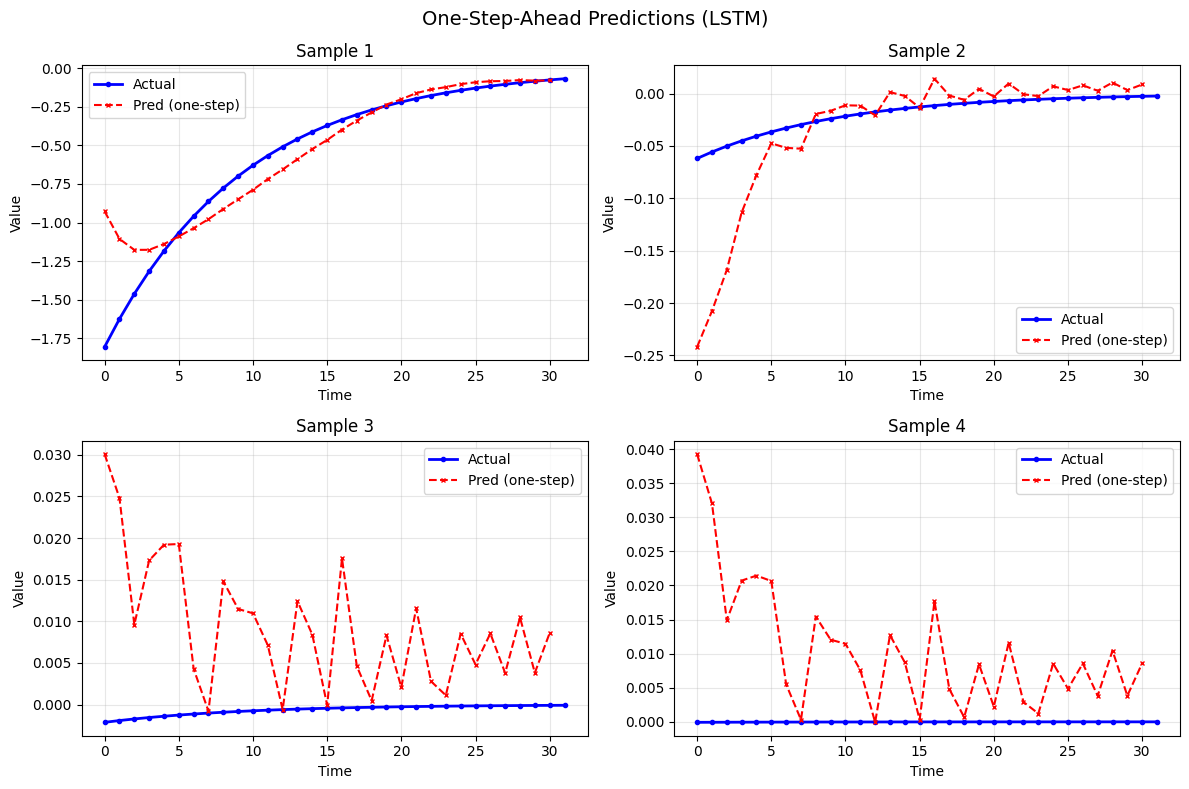

In [59]:
# Simple plot: one-step-ahead predictions vs actual (using full S context)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Get a test chunk (full S length)
    seq = np.array(x_test[i, :, 0])
    pred = np.array(preds_test[i, :, 0])
    
    t = np.arange(S)
    
    # Plot actual sequence
    ax.plot(t, seq, 'b-', linewidth=2, label='Actual', marker='o', markersize=3)
    
    # Plot one-step-ahead predictions (pred[t] predicts seq[t+1])
    ax.plot(t[:-1], pred[:-1], 'r--', linewidth=1.5, label='Pred (one-step)', marker='x', markersize=3)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(f'Sample {i+1}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('One-Step-Ahead Predictions (LSTM)', fontsize=14)
plt.tight_layout()
plt.show()

In [60]:
x_test.shape

(200, 32, 1)

In [61]:
preds_test.shape

(200, 32, 1)

In [62]:
# Autoregressive forecasting with GROUND TRUTH comparison
def autoregressive_forecast(params, initial_context, max_new_tokens):
    """
    Given initial_context of shape (B, S, 1), autoregressively predict max_new_tokens steps.
    Uses sliding window: always keep the last S values as input.
    
    Returns: (B, S + max_new_tokens, 1) - initial context + predictions
    """
    B = initial_context.shape[0]
    predictions = jnp.zeros((B, max_new_tokens, 1))
    predictions = jnp.concatenate([initial_context, predictions], axis=1)
    # predictions shape: (B, S + max_new_tokens, 1)
    
    for i in range(max_new_tokens):
        # Sliding window of size S: positions i to i+S
        ctx = predictions[:, i:i + S, :]
        pred = lstm.apply(params, ctx, train=False)
        next_val = pred[:, -1, :]  # shape (B, 1) - prediction at last position
        # Write to position i + S (next position after the context window)
        predictions = predictions.at[:, i + S, :].set(next_val)
    
    return np.array(predictions)

In [63]:
# Generate LONG test sequences (not chunked!) so we have ground truth continuation
n_future = 20
test_seqs, _, _ = gen(n_samples=batch_size, horizon=S + n_future + 10)  # Long enough for context + forecast

In [64]:
initial_context = test_seqs[:, :S, :1]
initial_context.shape

(32, 32, 1)

In [65]:
forecast = autoregressive_forecast(params, initial_context, max_new_tokens=60)

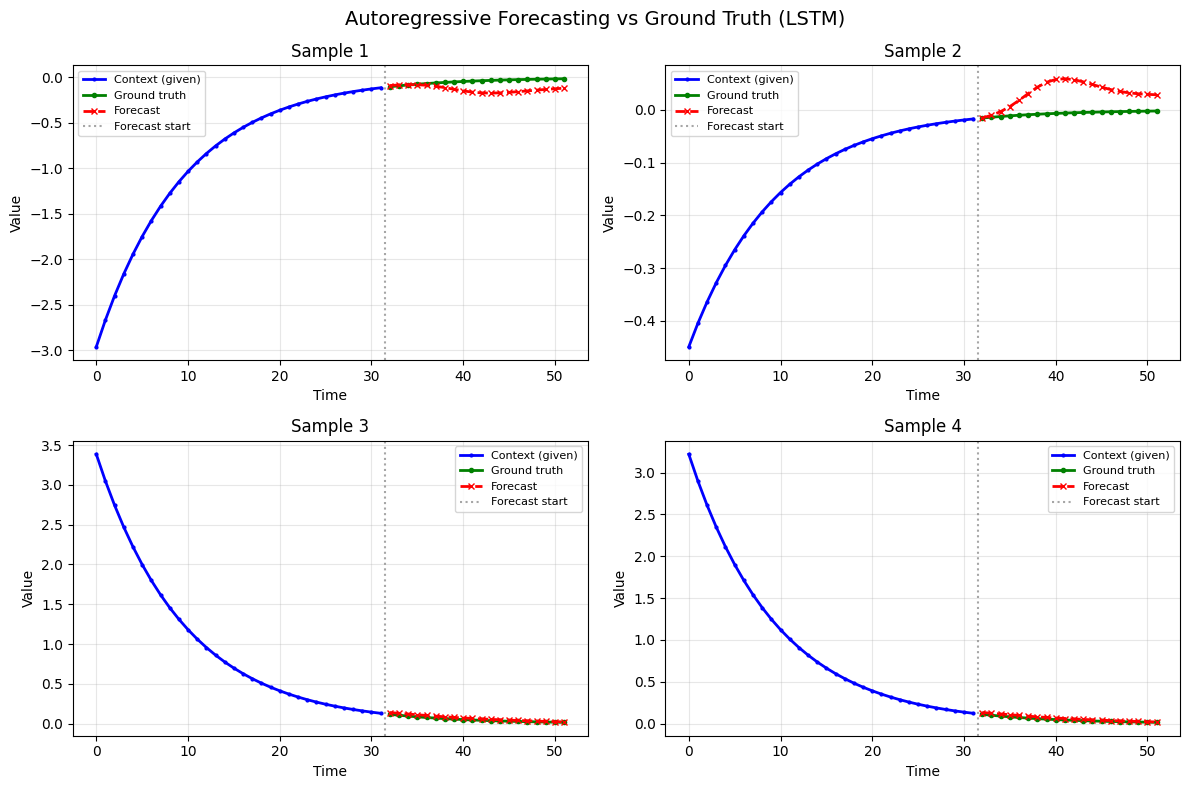

In [66]:
# Plot forecast vs ground truth
n_plot = min(n_future, forecast.shape[1] - S, test_seqs.shape[1] - S)  # How many future steps to plot

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Time indices
    t_context = np.arange(S)
    t_future = np.arange(S, S + n_plot)
    
    # Context (first S steps)
    ax.plot(t_context, test_seqs[i, :S, 0], 'b-', linewidth=2, label='Context (given)', marker='o', markersize=2)

    # Ground truth continuation
    ax.plot(t_future, test_seqs[i, S:S+n_plot, 0], 'g-', linewidth=2, label='Ground truth', marker='o', markersize=3)
    
    # Forecast
    ax.plot(t_future, forecast[i, S:S+n_plot, 0], 'r--', linewidth=2, label='Forecast', marker='x', markersize=4)
    
    ax.axvline(x=S-0.5, color='gray', linestyle=':', alpha=0.7, label='Forecast start')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(f'Sample {i+1}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Autoregressive Forecasting vs Ground Truth (LSTM)', fontsize=14)
plt.tight_layout()
plt.show()

In [67]:
test_seqs[0].shape, forecast[0].shape

((63, 2), (92, 1))

In [68]:
context = jnp.array(test_seqs[:, :S, :1])
pred = lstm.apply(params, context, train=False)

In [69]:
context.shape

(32, 32, 1)

In [70]:
pred.shape

(32, 32, 1)